### Viscoelastic contact with consrained conjugate gradient method

Based on the discussion on 29/03/2024, we have determined several parameters like shear modulus $G$ and Prony series for zener model with Kelvin representation, and we apply a comparison with Hertz solution for Kelvin representation.

![](figures/Representation_of_the_Standard_Linear_Solid.jpg)

Let's analysis step by step. First we consider an elastic material to check our backward Euler method.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
#define input parameters
##time
t0 = 0
t1 = 1
dt = (t1 - t0)/50
##load(constant)
W = 1e0  # Total load

#domain size
R = 1  # Radius of demi-sphere
L = 2  # Domain size
Radius = 0.5
S = L**2  # Domain area

# Generate a 2D coordinate space
n = 300
m = 300

x, y = np.meshgrid(np.linspace(0, L, n, endpoint=False), np.linspace(0, L, m, endpoint=False))

x0 = 1
y0 = 1


First we explain the shear modulus with Laplace transform, we start with the differential formulation for viscoelasticity:

$$
s\left(1+\frac{G_1}{G_0}\right)+\frac{\eta_1}{G_0} \dot{s}=2 G_1 e+2 \eta_1 \dot{e}
$$

When we assume shear modulus $G = 1$, and use combination of $G_0$ and $G_1$, we can apply Boussinesq potential in the Laplace domain, going back to the real domain, the viscoelastic Boussinesq equation can be given:

$$
\iint_{\Omega} \frac{1}{4 \pi \rho}\left(P(\xi, \eta)\left(1+\frac{G_1}{G_0}\right)+\frac{\eta_1}{G_0} \dot{P}(\xi, \eta)\right) d \xi d \eta=G_1 U_z(x, y)+\eta_1 \dot{U}_z(x, y)
$$

With $G = 1$ and Lamé parameters relationship for homogeneous isotropic linear elastic materials:

$$
E  =2 G(1+v)
$$

In [97]:
E = 3  # Young's modulus
nu = 0.5
E_star = E / (1 - nu**2)  # Plane strain modulus

In [98]:

##################################################################
#####First just apply for demi-sphere and compare with Hertz######
##################################################################

# We define the distance from the center of the sphere
r = np.sqrt((x-x0)**2 + (y-y0)**2)

# Define the kernel in the Fourier domain
q_x = 2 * np.pi * np.fft.fftfreq(n, d=L/n)
q_y = 2 * np.pi * np.fft.fftfreq(m, d=L/m)
QX, QY = np.meshgrid(q_x, q_y)

kernel_fourier = np.zeros_like(QX)
kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))
kernel_fourier[0, 0] = 0  # Avoid division by zero at the zero frequency


h_profile = -(r**2)/(2*Radius)

def apply_integration_operator(Origin, kernel_fourier, h_profile):
    # Compute the Fourier transform of the input image
    Origin2fourier = np.fft.fft2(Origin, norm='ortho')

    Middle_fourier = Origin2fourier * kernel_fourier

    Middle = np.fft.ifft2(Middle_fourier, norm='ortho').real

    Gradient = Middle - h_profile

    return Gradient, Origin2fourier#true gradient


/var/folders/8h/9pns8j3d2sl62pk5rmmfs01h0000gn/T/ipykernel_36327/32090082.py:14: RuntimeWarning: divide by zero encountered in divide
  kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))


In [99]:
def contact_solver(n, m, W, S, E_star, h_profile, tol=1e-6, iter_max=200):
    

    # Initial pressure distribution
    P = np.full((n, m), W / S)  # Initial guess for the pressure

    #initialize the search direction
    T = np.zeros((n, m))

    #set the norm of surface(to normalze the error)
    h_rms = np.std(h_profile)

    #initialize G_norm and G_old
    G_norm = 0
    G_old = 1

    #initialize delta
    delta = 0

    # Initialize variables for the iteration
    k = 0  # Iteration counter
    error = np.inf  # Initialize error
    h_rms = np.std(h_profile)

    while np.abs(error) > tol and k < iter_max:
    # try np.where(P > 0) to find the contact area
        S = P > 0

        #encapsulate into a function

        # Calculate the gap G(as Gradient, see Lucas(2020)) in the Fourier domain and transform it back to the spatial domain
        #P_fourier = np.fft.fft2(P, norm='ortho')
        #G_fourier = P_fourier * kernel_fourier
        #G = np.fft.ifft2(G_fourier, norm='ortho').real - h_profile
        ##function

        G, P_fourier = apply_integration_operator(P, kernel_fourier, h_profile)

        G -= G[S].mean()

        G_norm = np.linalg.norm(G[S])**2

        # Calculate the search direction
        T[S] = G[S] + delta * G_norm / G_old * T[S]
        T[~S] = 0  ## out of contact area, dont need to update
        ## size dont match

        # Update G_old
        G_old = G_norm

        # Set R
        R, T_fourier  = apply_integration_operator(T, kernel_fourier, h_profile)
        R += h_profile
        R -= R[S].mean()

        # Calculate the step size tau
        #######
        tau = np.vdot(G[S], T[S]) / np.vdot(R[S], T[S])

        # Update P
        P -= tau * T        
        P *= P > 0

        # identify the inadmissible points
        R = (P == 0) & (G < 0)

        if R.sum() == 0:
            delta = 1
        else:
            delta = 0#change the contact point set and need to do conjugate gradient again

        # Apply positive pressure on inadmissible points       
        #P[R] -= tau * G[R]


        # Enforce the applied force constraint
        P = W * P / np.mean(P) / L**2  ## be wise here#############
        ##############################



        # Calculate the error for convergence checking
        error = np.vdot(P, (G - np.min(G))) / (P.sum()*h_rms) 
        print(delta, error, k, np.mean(P), np.mean(P>0), tau)
        
        k += 1  # Increment the iteration counter


    # Ensure a positive gap by updating G
    G = G - np.min(G)

    displacement_fourier = P_fourier * kernel_fourier
    displacement = np.fft.ifft2(displacement_fourier, norm='ortho').real

    return displacement, P



In [100]:

#first we only consider one branch
G_0 = 2.75  # MPa
G_1 = 2.75  # MPa
G_inf = 1/(1/G_0 + 1/G_1)  # MPa

print('G_inf:', G_inf)

G_inf: 1.375


The relaxation time  $\tau_0$ (or called the characteristic time of the creep compliance function[1]) is typically defined as the ratio of the dashpot's viscosity $\eta_0$ to the spring's modulus $G_1$ that it is in parallel with, not the series spring modulus $G_0$. So, it would be:

$$ \tau_0 = \frac{\eta_1}{G_1} $$

Then for elastic material, $\tau_0$ should be set 0.

In [101]:
tau_0 = 0.01  # s
eta_1 = G_1 * tau_0  # Characteristic time

![](figures/what_we_get_elastic.jpg)
![](figures/what_we_expect_elastic.jpg)

In [102]:
#######################################
###if we let k_branch=1, we can compare the real contact area with hertz solution at t=0 and t>>\tau_0
#######################################
k_branch = 1

alpha = G_inf + (G_1 + eta_1/dt)/(1 + G_1/G_0 + eta_1/G_0/dt)
#alpha = 1/2 * alpha
print('alpha:', alpha)
print('G_inf * 2:', G_inf*2)

beta = (eta_1/dt)/(1+G_1/G_0+eta_1/G_0/dt)
gamma = (eta_1/G_0/dt)/(1+G_1/G_0+eta_1/G_0/dt)

Surface = h_profile

U = np.zeros((n, m))
M = np.zeros((n, m))

Ac=[]

for t in np.arange(t0, t1, dt):
    #main step0: Update the effective modulus
    #effictive modulus
    #G_t = G_inf + G_1 * np.exp(-t/tau_0)

    #E_star = G_t
    

    #main step1: Update the surface profile
    H_new = alpha*Surface - beta*U + gamma*M

    #main step2: Update the displacement field
    U_new, P = contact_solver(n, m, W, S, E_star, H_new, tol=1e-6, iter_max=200)
    ###const no need to update the loading field W_new


    Ac.append(np.mean(P > 0)*S)



    #main step3: Update the partial displacement field
    M = (G_0*dt/((G_0+G_1)*dt+eta_1))*(eta_1*M /G_0/dt + (G_1+eta_1/dt)*U_new -eta_1*U/dt)

    #main step4: Update the total displacement field
    U = U_new

alpha: 3.025
G_inf * 2: 2.75
1 0.5369923870480035 0 0.24999999999999997 0.5333444444444444 6.558428532876951
1 0.2813606466961878 1 0.24999999999999997 0.30356666666666665 9.458980755666886
1 0.1536868241280733 2 0.25000000000000006 0.1893 11.406753558357757
1 0.07935329449838262 3 0.24999999999999997 0.12996666666666667 13.916668827823013
1 0.03271344540491618 4 0.25 0.10094444444444445 17.30302782551052
1 0.0048047928238175944 5 0.24999999999999997 0.08841111111111111 23.87516446859208
1 0.0027219078096639275 6 0.24999999999999997 0.08196666666666666 56.19726854484401
1 0.003520443024442197 7 0.25 0.0801 45.80516233034495
1 0.0010355435291513678 8 0.25000000000000006 0.07938888888888888 61.68015171329169
1 0.00034569841706007026 9 0.24999999999999997 0.07876666666666667 72.33049831424867
1 0.00024983172779947027 10 0.24999999999999997 0.07814444444444445 66.39640718627409
1 0.0003624663623024628 11 0.25000000000000006 0.07805555555555556 61.82900383991474
1 0.00021489707067164264 12 

1 0.000537250570289344 11 0.24999999999999997 0.08894444444444445 40.060990465872166
1 0.00013114055371643782 12 0.25 0.08876666666666666 59.33253774918481
1 0.00012574123314409015 13 0.24999999999999997 0.08876666666666666 42.36045299892516
1 6.0218945754392144e-05 14 0.25 0.08876666666666666 65.99460404916124
1 0.00011447781083399784 15 0.24999999999999997 0.08876666666666666 61.52411773052354
1 9.759550583076576e-05 16 0.25 0.08867777777777777 71.09819073922787
1 4.390409065344072e-05 17 0.24999999999999997 0.08867777777777777 77.40906541300906
1 3.060253591562198e-05 18 0.25000000000000006 0.08858888888888888 51.22115454926824
1 3.599466091521751e-05 19 0.25 0.08858888888888888 71.72173359291507
1 2.6105507850333762e-05 20 0.25 0.0885 62.50082412247316
1 1.7321288967893626e-05 21 0.25 0.0885 76.18706481489554
1 9.438152844158711e-06 22 0.25 0.0885 50.82508267764388
1 5.47191472181674e-06 23 0.25000000000000006 0.0885 70.55828815627963
1 7.613380828387892e-06 24 0.25 0.0885 49.52847

#### Hertz solution reference for one-branch viscoelastic model

Prony series for kelvin model can be expressed as:

$$
G_t=G_{\infty}+\left(G_0-G_{\infty}\right) e^{-t / t_0}
$$

Then the anlytical solution of contact area should be:


$$
\begin{aligned}
& A_c(t=0)=f_{\text {Hertz }}\left(W, G_0\right) \\
& A_c(t=\infty)=f_{\text {Hertz }}\left(W, G_{\infty}\right)
\end{aligned}
$$

Our expected output figure is:

![](figures/expected_plot.jpg)



/var/folders/8h/9pns8j3d2sl62pk5rmmfs01h0000gn/T/ipykernel_36327/3828212105.py:17: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x[n//2], p0_t0*np.sqrt(1 - (x[n//2]-x0)**2 / a_t0**2))
/var/folders/8h/9pns8j3d2sl62pk5rmmfs01h0000gn/T/ipykernel_36327/3828212105.py:18: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x[n//2], p0_t_inf*np.sqrt(1 - (x[n//2]-x0)**2 / a_t_inf**2))


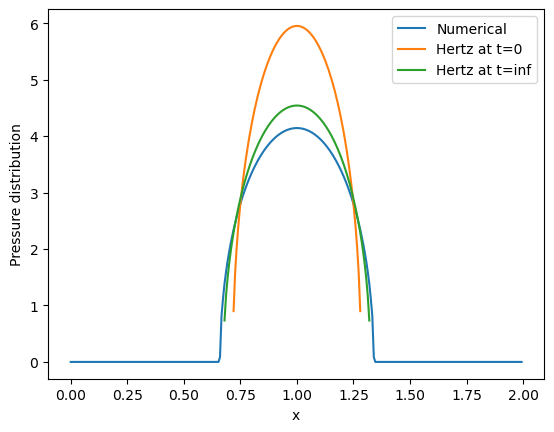

In [103]:
#######################################
###Hertzian contact theory reference
#######################################
##Hertz solution at t0    
E_effective_t0 = 2*(3/2)*G_0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_0*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


plt.plot(x[n//2], P[n//2])
plt.plot(x[n//2], p0_t0*np.sqrt(1 - (x[n//2]-x0)**2 / a_t0**2))
plt.plot(x[n//2], p0_t_inf*np.sqrt(1 - (x[n//2]-x0)**2 / a_t_inf**2))
plt.legend(["Numerical", "Hertz at t=0", "Hertz at t=inf"])
plt.xlabel("x")
plt.ylabel("Pressure distribution")
plt.show()

Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Analytical contact area radius at t0: 0.2832581674713524
Analytical contact area radius at t_inf: 0.32424965862401395
Analytical maximum pressure at t0: 5.9508157531967285
Analytical maximum pressure at t_inf: 4.541322364996685
Numerical contact area at t0: 0.3100888888888889
Numerical contact area at t_inf 0.3643111111111111
Analyical contact area at t0: 0.2520662817016663
Analyical contact area at t_inf: 0.3303002692699386


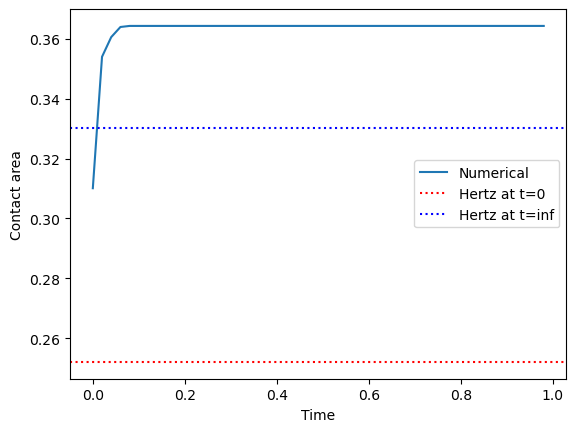

In [104]:
print("Analytical contact area radius at t0:", a_t0)
print("Analytical contact area radius at t_inf:", a_t_inf)
print("Analytical maximum pressure at t0:", p0_t0)
print("Analytical maximum pressure at t_inf:", p0_t_inf)
print("Numerical contact area at t0:", Ac[0])
print("Numerical contact area at t_inf",  Ac[-1])
print("Analyical contact area at t0:", Ac_hertz_t0)
print("Analyical contact area at t_inf:", Ac_hertz_t_inf)
plt.plot(np.arange(t0, t1, dt), Ac)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time")
plt.ylabel("Contact area")
plt.legend(["Numerical", "Hertz at t=0", "Hertz at t=inf"])
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()

### Reference:

[1] Bugnicourt, R., P. Sainsot, N. Lesaffre, and A.A. Lubrecht. ‘Transient Frictionless Contact of a Rough Rigid Surface on a Viscoelastic Half-Space’. Tribology International 113 (September 2017): 279–85. https://doi.org/10.1016/j.triboint.2017.01.032.

[2] Van Dokkum, Jan Steven, and Lucia Nicola. ‘Green’s Function Molecular Dynamics Including Viscoelasticity’. Modelling and Simulation in Materials Science and Engineering 27, no. 7 (1 October 2019): 075006. https://doi.org/10.1088/1361-651X/ab3031.